# Using CNN to extract data from plots

- We'll start by making synthetic images of plots that look like "real" log plots
- Train a 5-6 layer CNN using Keras
- Return 20 inferred points from the RGB image fed. (the idea is to segment the log in chunks)
- Repeat until it works

TODO:
- Use OCR output to scale points extracted to physical units
- Expand the amount of points extracted (from 20 to 100s?)
- Test/Generate other types of log plots.

In [1]:
import pylab as plt
# %matplotlib inline

In [2]:
import numpy as np

Synthetic image generation function:

In [4]:
def gen_im(n=1):
    
    rn = np.random.uniform(low=0, high=1, size=(20,))
    # Make a random plot...
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(rn,"r")
    ax.grid()
    
    DPI = fig.get_dpi()
    fig.set_size_inches(150/float(DPI),150/float(DPI))
#     fig.set_size_inches(3,3)
    fig.canvas.draw()

    # Now we can save it to a numpy array.
    data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
#     data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    plt.close('all')

    return data, rn, fig.canvas.get_width_height()[::-1]

In [5]:
_,_,size = gen_im(n=1)

Batch image generation function:

In [6]:
def batch_gen(n=1):
    for i in range(n):
        if i==0:
            arr, vals, size = gen_im()
        else:
            tmparr, tmpvals, size = gen_im()
            arr = np.vstack((arr,tmparr))
            vals = np.vstack((vals,tmpvals))
            
    arr = arr.reshape(arr.shape[0], *size, 3)[:,:,:,:]
    
    return arr, vals

Let's start with 1000 training samples and 100 test samples

In [7]:
x_train, y_train = batch_gen(n=1000)
x_test, y_test = batch_gen(n=100)

We reshaped the images to be squared just because it's easier. Here's how they look:

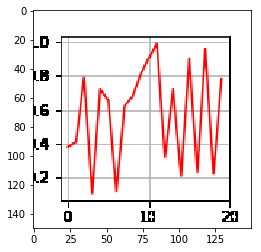

In [11]:
plt.imshow(x_train[0,:].reshape(*size,3))
plt.show()

# CNN

Let's implement CNN's until they work!

In [10]:
import keras

from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.layers.convolutional import ZeroPadding2D
from keras.layers import Activation
from keras.optimizers import SGD

import matplotlib.pylab as plt

batch_size = 1
num_classes = 20
epochs = 10

# input image dimensions
img_x, img_y = size


input_shape = (img_x, img_y, 3)


print('x_train shape:', x_train.shape)

Using TensorFlow backend.


x_train shape: (1000, 150, 150, 3)
1000 train samples
100 test samples


In [14]:
filter_size = 3
pool_size = 2


model = Sequential([
        Conv2D(32, (6, 6), input_shape=input_shape, data_format="channels_last", activation='relu'), 
        MaxPooling2D(pool_size=(pool_size, pool_size)), 
        Conv2D(64, (filter_size, filter_size), data_format="channels_last", activation='relu'), 
        MaxPooling2D(pool_size=(pool_size, pool_size)), 
        Conv2D(128, (filter_size, filter_size), data_format="channels_last", activation='relu'), 
# #         MaxPooling2D(pool_size=(pool_size, pool_size)), 
        Conv2D(128, (filter_size, filter_size), data_format="channels_last", activation='relu'), 
# #         MaxPooling2D(pool_size=(pool_size, pool_size)), 
        Flatten(), 
#         Dropout(0.4), 
#         Dense(1000, activation='relu'), 
        Dropout(0.4), 
        Dense(num_classes, activation='linear'),
    ])


model.compile('adadelta', 'mse')


# Train

In [15]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[history])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score)

Train on 1000 samples, validate on 100 samples
Epoch 1/10
1000/1000 [==============================] - 16s - loss: 23.8414 - val_loss: 0.0927
Epoch 2/10
1000/1000 [==============================] - 15s - loss: 0.1216 - val_loss: 0.0906
Epoch 3/10
1000/1000 [==============================] - 15s - loss: 0.0614 - val_loss: 0.0169
Epoch 4/10
1000/1000 [==============================] - 15s - loss: 0.0237 - val_loss: 0.0128
Epoch 5/10
1000/1000 [==============================] - 15s - loss: 0.0161 - val_loss: 0.0093
Epoch 6/10
1000/1000 [==============================] - 15s - loss: 0.0122 - val_loss: 0.0054
Epoch 7/10
1000/1000 [==============================] - 15s - loss: 0.0100 - val_loss: 0.0052
Epoch 8/10
1000/1000 [==============================] - 15s - loss: 0.0081 - val_loss: 0.0043
Epoch 9/10
1000/1000 [==============================] - 15s - loss: 0.0068 - val_loss: 0.0043
Epoch 10/10
1000/1000 [==============================] - 15s - loss: 0.0059 - val_loss: 0.0036
Test loss: 

Previous run took ~10mins

# Results so far...

In [16]:
model.predict(x_test[0].reshape(1,*size, 3))

array([[ 0.71531039,  0.25573358,  0.38671073,  0.26387516,  0.20936851,
         0.09122981,  0.31036615,  0.93483704,  0.84296411,  0.53192335,
         0.42021567, -0.00397748,  0.8535108 ,  0.34259772,  0.89033818,
         0.62802362,  0.9279604 ,  0.28351635,  0.18970332,  0.16144234]], dtype=float32)

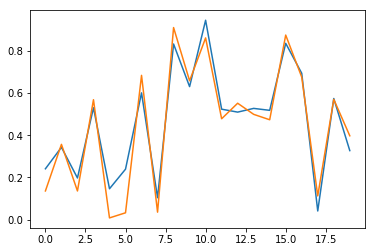

In [18]:
plt.plot(model.predict(x_test)[0])
plt.plot(y_test[0])
plt.show()

Not bad at all!

# For our last trick before we run out of time, a real image!

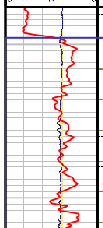

In [42]:
from PIL import Image
im = Image.open("log_crop_smaller.png")
im

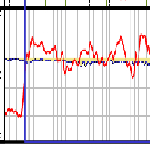

In [43]:
im = im.resize((150,150)).rotate(90)
im

In [53]:
im_arr = np.array(im.getdata())[:,:-1].reshape(1, im.size[1], im.size[0], 3)

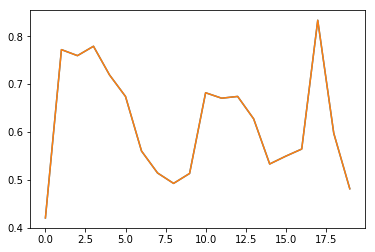

In [58]:

plt.plot(model.predict(im_arr)[0])
plt.show()

Trying to lineup things:

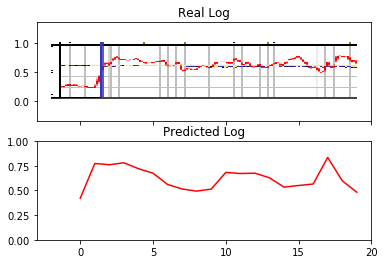

In [80]:
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)
ax0.imshow(im, extent=(-2, 19, 0, 1), aspect=4)
ax0.set_title('Real Log')
ax0.set_xlim(-3,20)

ax1.plot(model.predict(im_arr)[0],'r')
ax1.set_title('Predicted Log')
ax1.set_ylim(0,1)

plt.show()